# 신경망 모델 훈련

## 손실 곡선

In [1]:
from tensorflow import keras
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()

train_scaled = train_input / 255.0

train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size=0.2, random_state=42)

4423680/4422102 [==============================] - 0s 0us/step


In [2]:
def model_fn(a_layer=None):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28, 28)))
    model.add(keras.layers.Dense(100, activation='relu'))
    if a_layer:
        model.add(a_layer)
    model.add(keras.layers.Dense(10, activation='softmax'))
    return model

In [3]:
model = model_fn()

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [4]:
#accuracy 지정하지 않으면 loss만 저장됨
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')

history = model.fit(train_scaled, train_target, epochs=5, verbose=0)

In [6]:
print(history.history.keys())

dict_keys(['loss', 'accuracy'])


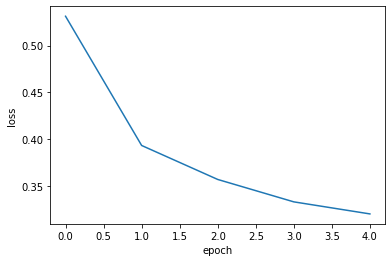

In [7]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig('7_3-01', dpi=300)
plt.show()

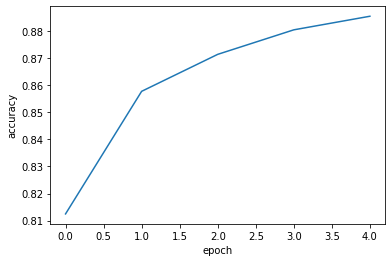

In [8]:
plt.plot(history.history['accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.savefig('7_3-02', dpi=300)
plt.show()

In [9]:
#에포크 20으로 늘려서 시험
model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')

history = model.fit(train_scaled, train_target, epochs=20, verbose=0)

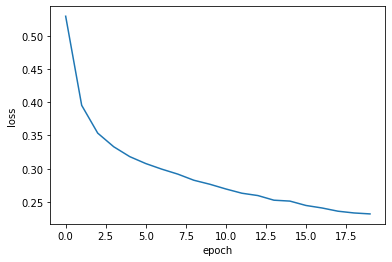

In [10]:
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig('7_3-03', dpi=300)
plt.show()

## 검증 손실

In [11]:
model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')

history = model.fit(train_scaled, train_target, epochs=20, verbose=0, 
                    validation_data=(val_scaled, val_target))

In [12]:
print(history.history.keys())
#val_loss추가됨

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


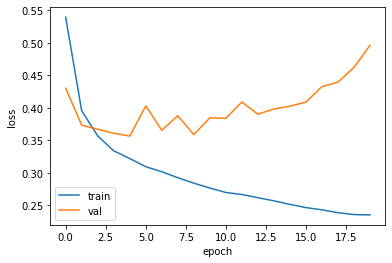

In [13]:
#과대 적합된 모델
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.savefig('7_3-04', dpi=300)
plt.show()

In [14]:
model = model_fn()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

history = model.fit(train_scaled, train_target, epochs=20, verbose=0, 
                    validation_data=(val_scaled, val_target))

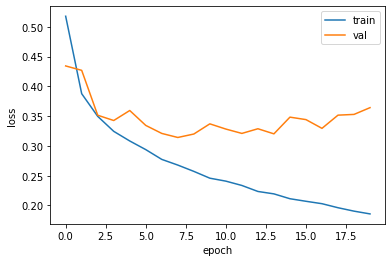

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.savefig('7_3-05', dpi=300)
plt.show()

## 드롭아웃

In [16]:
#신경망에서 사용될 수 있는 규제 방법

#은닉층에서 몇퍼센트를 끌지 지정(훈련할 때만 꺼줌)
model = model_fn(keras.layers.Dropout(0.3))
#은닉층의 입력과 동일

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 100)               78500     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                1010      
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

history = model.fit(train_scaled, train_target, epochs=20, verbose=0, 
                    validation_data=(val_scaled, val_target))

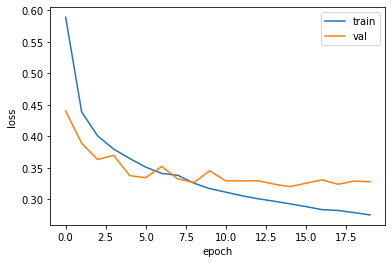

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.savefig('7_3-06', dpi=300)
plt.show()

## 모델 저장과 복원

In [19]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

history = model.fit(train_scaled, train_target, epochs=10, verbose=0, 
                    validation_data=(val_scaled, val_target))

In [20]:
# 가중치만 저장
model.save_weights('model-weights.h5')

In [21]:
#모델 구조와 가중치 저장
model.save('model-whole.h5')

In [22]:
!ls -al *.h5

-rw-r--r-- 1 root root 332480 Feb 23 12:14 model-weights.h5
-rw-r--r-- 1 root root 981776 Feb 23 12:14 model-whole.h5


In [23]:
model = model_fn(keras.layers.Dropout(0.3))

#가중치 불러옴
model.load_weights('model-weights.h5')

In [24]:
import numpy as np

val_labels = np.argmax(model.predict(val_scaled), axis=-1)
print(np.mean(val_labels == val_target))

0.8786666666666667


In [25]:
#모델과 가중치 불러옴
model = keras.models.load_model('model-whole.h5')
# 텐서플로 2.3에서는 버그(https://github.com/tensorflow/tensorflow/issues/42890) 때문에 compile() 메서드를 호출해야 합니다.
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 2ms/step - loss: 0.3395 - accuracy: 0.8787


[0.3395325839519501, 0.8786666393280029]

## 콜백

In [26]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
#가장 낮은 손실 가진 모델 저장
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5')

model.fit(train_scaled, train_target, epochs=20, verbose=0, 
          validation_data=(val_scaled, val_target),
          callbacks=[checkpoint_cb])

In [27]:
model = keras.models.load_model('best-model.h5')
# 텐서플로 2.3에서는 버그(https://github.com/tensorflow/tensorflow/issues/42890) 때문에 compile() 메서드를 호출해야 합니다.
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 2ms/step - loss: 0.3245 - accuracy: 0.8863


[0.3244858980178833, 0.8862500190734863]

In [28]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5')


early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,
                                                  restore_best_weights=True)

history = model.fit(train_scaled, train_target, epochs=20, verbose=0, 
                    validation_data=(val_scaled, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

In [29]:
print(early_stopping_cb.stopped_epoch)

13


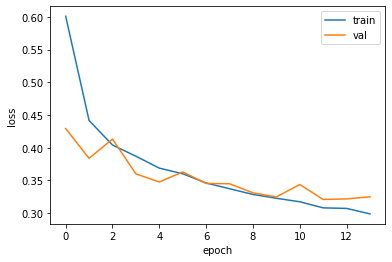

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.savefig('7_3-07', dpi=300)
plt.show()

In [33]:
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 2ms/step - loss: 0.3209 - accuracy: 0.8878


[0.32094621658325195, 0.8878333568572998]